In [9]:
from BinaryLayers import *

In [10]:
# For Binary Layers
H = 1
deterministic = True

# For Training
batch_size = 64
num_epochs = 200

# For batchnorm
epsilon = 1e-4
alpha = .1

# For the optimizer
learning_rate = .3
min_learning_rate = 3e-5
decay = (learning_rate - min_learning_rate) / num_epochs

# Set GPU
device = torch.device("cuda")

In [11]:
class nn(Module):
    def __init__(self):
        super(nn, self).__init__()

        self.c3_128_1 = BinaryConv2D(3, 128, 3, padding=1, H=H, deterministic=deterministic)
        self.bn_1 = torch.nn.BatchNorm2d(128, eps=epsilon, momentum=alpha)

        self.c3_128_2 = BinaryConv2D(128, 128, 3, padding=1, H=H, deterministic=deterministic)
        self.mp2_2 = torch.nn.MaxPool2d(2)
        self.bn_2 = torch.nn.BatchNorm2d(128, eps=epsilon, momentum=alpha)

        self.c3_256_3 = BinaryConv2D(128, 256, 3, padding=1, H=H, deterministic=deterministic)
        self.bn_3 = torch.nn.BatchNorm2d(256, eps=epsilon, momentum=alpha)

        self.c3_256_4 = BinaryConv2D(256, 256, 3, padding=1, H=H, deterministic=deterministic)
        self.mp2_4 = torch.nn.MaxPool2d(2)
        self.bn_4 = torch.nn.BatchNorm2d(256, eps=epsilon, momentum=alpha)

        self.c3_512_5 = BinaryConv2D(256, 512, 3, padding=1, H=H, deterministic=deterministic)
        self.bn_5 = torch.nn.BatchNorm2d(512, eps=epsilon, momentum=alpha)

        self.c3_512_6 = BinaryConv2D(512, 512, 3, padding=1, H=H, deterministic=deterministic)
        self.mp2_6 = torch.nn.MaxPool2d(2)
        self.bn_6 = torch.nn.BatchNorm2d(512, eps=epsilon, momentum=alpha)

        self.d_1024_7 = BinaryDense(2048 * 4, 1024, H=H, deterministic=deterministic)
        self.bn_7 = torch.nn.BatchNorm1d(1024, eps=epsilon, momentum=alpha)
        
        self.d_1024_8 = BinaryDense(1024, 1024, H=H, deterministic=deterministic)
        self.bn_8 = torch.nn.BatchNorm1d(1024, eps=epsilon, momentum=alpha)

        self.d_10_9 = BinaryDense(1024, 10, H=H, deterministic=deterministic)

    def forward(self, input):
        x = self.c3_128_1(input)
        x = torch.nn.ReLU()(self.bn_1(x))
#         print(x.shape)
        x = self.c3_128_2(x)
        x = self.mp2_2(x)
        x = torch.nn.ReLU()(self.bn_2(x))
#         print(x.shape)

        x = self.c3_256_3(x)
        x = torch.nn.ReLU()(self.bn_3(x))
#         print(x.shape)
        x = self.c3_256_4(x)
        x = self.mp2_4(x)
        x = torch.nn.ReLU()(self.bn_4(x))
#         print(x.shape)

        x = self.c3_512_5(x)
        x = torch.nn.ReLU()(self.bn_5(x))
#         print(x.shape)
        x = self.c3_512_6(x)
        x = self.mp2_6(x)
        x = torch.nn.ReLU()(self.bn_6(x))
#         print(x.shape)

        x = torch.nn.Flatten()(x)
        
        x = self.d_1024_7(x)
        x = torch.nn.ReLU()(self.bn_7(x))
#         print(x.shape)

        x = self.d_1024_8(x)
        x = torch.nn.ReLU()(self.bn_8(x))
#         print(x.shape)

        x = self.d_10_9(x)
        x = torch.nn.Softmax(-1)(x)
        return x

In [12]:
model = nn().to(device)

In [13]:
model

nn(
  (c3_128_1): BinaryConv2D(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
  (c3_128_2): BinaryConv2D(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp2_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn_2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
  (c3_256_3): BinaryConv2D(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
  (c3_256_4): BinaryConv2D(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp2_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn_4): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
  (c3_512_5): BinaryConv2D(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_5): BatchNor

In [14]:
t = transforms.Compose(
    [
       transforms.ToTensor(),
       transforms.Normalize(mean=(0), std=(1))
    ]
)

dl_train = DataLoader(
    torchvision.datasets.CIFAR10(
        "/data/cifar",
        download=True,
        train=True,
        transform=t,
        target_transform=torchvision.transforms.Compose([
            lambda x:torch.LongTensor([x]), # or just torch.tensor
            lambda x:torch.nn.functional.one_hot(x, 10)
        ])
    ),
    batch_size=batch_size,
    drop_last=True,
    shuffle=True
)
dl_test = DataLoader(
    torchvision.datasets.CIFAR10(
        "/data/cifar",
        download=True,
        train=False,
        transform=t,
        target_transform=torchvision.transforms.Compose([
            lambda x:torch.LongTensor([x]), # or just torch.tensor
            lambda x:torch.nn.functional.one_hot(x, 10)
        ])
    ),
    batch_size=batch_size,
    drop_last=True,
    shuffle=True
)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
# loss = SquareHingeLoss
loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=decay)

In [18]:
def train(model, num_epochs, dl_train, dl_valid, optimizer, lossfunction):
    losses = [0] * num_epochs
    val_losses = [0] * num_epochs
    accuracy = [0] * num_epochs
    
    total_steps = len(dl_train) * num_epochs
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}")
        # Start training
        model.train()
        for i, (input, target) in enumerate(dl_train):
            if i % 10 == 0:
                print(i, end=" ")
            optimizer.zero_grad()
#             input = torch.reshape(input, (-1, 32 * 32)).to(device)
            input = input.to(device)
            target = torch.reshape(target, (-1, 10)).to(device)
            output = model(input)

            loss = lossfunction(output, target.float())
            losses[epoch] += loss.item()
            loss.backward()
            
            optimizer.step()
            
        model.eval()
        tot_acc = 0
        with torch.no_grad():
            for j, (input, target) in enumerate(dl_valid):
#                 input = torch.reshape(input, (-1, 32 * 32)).to(device)
                input = input.to(device)
                target = target.reshape((-1, 10)).to(device)
                output = model(input)
                loss = lossfunction(output, target.float())
                val_losses[epoch] += loss.item()
                tot_acc = (tot_acc * j + int(sum(torch.argmax(target, -1) == torch.argmax(output, -1))) / len(target)) / (j + 1)
        accuracy[epoch] = tot_acc

        print("")
        print("Epoch training loss" , losses[epoch] / len(dl_train))
        print("Epoch valid loss" , val_losses[epoch] / len(dl_valid))
        print("Validation Accuracy:", tot_acc)
    return losses, val_losses, accuracy

In [19]:
losses, val_losses, accuracy = train(model, num_epochs, dl_train, dl_test, optimizer, loss)

Epoch 1
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 
Epoch training loss 0.1509904336284431
Epoch valid loss 0.1391333234615815
Validation Accuracy: 0.2864583333333335
Epoch 2
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 
Epoch training loss 0.1333512716023931
Epoch valid loss 0.13089958530588028
Validation Accuracy: 0.3310296474358976
Epoch 3
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 

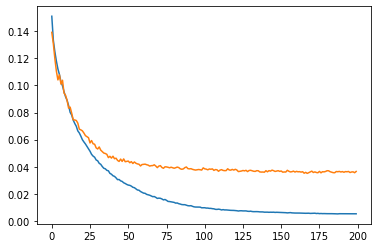

In [21]:
import matplotlib.pyplot as plt
plt.plot([loss / len(dl_train) for loss in losses])
plt.plot([val_loss / len(dl_test) for val_loss in val_losses])